In [29]:
%reset -f

In [30]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import re
import glob
import io
plt.rcParams.update({'figure.dpi': 120})

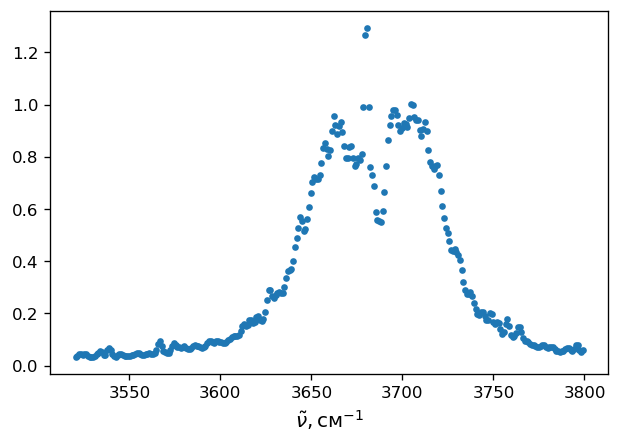

In [31]:
xy = np.loadtxt('67-56-1-IR_1.9cm-1.jdx.txt') #CH3-OH
#xy = np.loadtxt('67-56-1-IR.jdx.txt') #CH3-OH
idx = np.where((xy[:, 0]>3520)&(xy[:,0]<3800))[0]

xy = xy[idx]
xy[:, 1] /= np.percentile(xy[:,1], 99)

#plt.figure(figsize=(5.8,3))
plt.plot(*tuple(xy.T), '.')
plt.xlabel(r'$\tilde{\nu}, \mathrm{см}^{-1}$', fontsize=12)
plt.show()


In [32]:
import scipy.optimize as sp_opt

In [33]:
min(xy[:,1])

0.031977940862436514

### частина 1 - апроксимація лоренцевим контуром 
$$
y(x) = y_0  + \frac{a}{{1 + \left( {\frac{{x - x_0 }}{w}} \right)^2 }}
$$
Така $y(x)$ - функція 4 параметрів: $y_0$ ("нульовий рівень"), $a$ ("висота" піку), $x_0$ (координата максимуму), $w$ (характерна ширина)

In [41]:
t = np.linspace(min(xy[:,0]), max(xy[:,0]), 1000)

def peak_fit(p, t, returnType = 0): # 0 -> y, 1 -> ||dy||^2, 2 -> ||dy||^2, grad
    #a, x0, hw = p
    a, x0, hw, y0 = p
    
    x = t - x0    
    derivs = np.zeros((len(p), len(t)))
    
    fval = 1./( (x/hw)**2 + 1 )
    
    derivs[0] = fval
    derivs[1] = fval**2/hw**2 * 2*x * a
    derivs[2] = fval**2 * x**2 * 2./hw**3 * a
    derivs[3] = 1.
    y = fval * a + y0
        

    if returnType == 0:
        return y
    else:
        dy = y - xy[:, 1]
        if returnType == 1:
            return dy.dot(dy)
        else:
            return dy.dot(dy), 2. * derivs.dot(dy)
#


In [42]:
# checking derivatives...
p0 = np.array([1., 3680, 2.5, 0.2])
sp_opt.approx_fprime(p0, peak_fit, 1e-8, xy[:, 0], 1)

array([ -3.34462307,   0.09989094,  -1.94977119, -58.86640153])

In [43]:
peak_fit(p0, xy[:, 0], 2)

(29.283731291073707,
 array([ -3.34462347,   0.09989214,  -1.94977123, -58.86640468]))

      fun: 2.961268028308481
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.45714442e-06, -4.01626086e-07, -5.74394381e-08, -2.26765264e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 37
      nit: 27
   status: 0
  success: True
        x: array([ 1.07170083e+00,  3.68549018e+03,  4.66735358e+01, -1.14093734e-01])


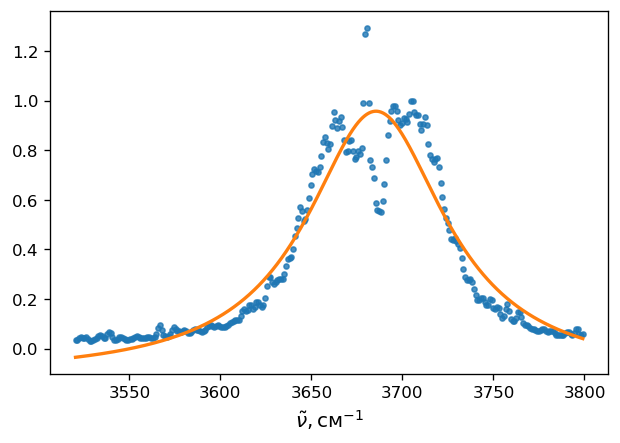

In [47]:
p0[1] = 3680
#p0[1] = 3560 # negative a ?
plt.plot(xy[:,0], xy[:,1], '.', alpha=0.8)
if 0:
    y = peak_fit(p0, t, 0)
    plt.plot(t,y)
else:
    res = sp_opt.minimize(peak_fit, p0, args=(xy[:, 0], 2),
                          method='l-bfgs-b', 
                          #method='cg',
                          jac=True,
                          #bounds = [(0,1e10)]* len(p0)
                         )
                          #options=dict(maxiter=200, ftol=1e-20,gtol=1e-10))
    print(res)
    y = peak_fit(res.x, t, 0)
    plt.plot(t,y, linewidth=2)
plt.xlabel(r'$\tilde{\nu}, \mathrm{см}^{-1}$', fontsize=12)
plt.show()
    

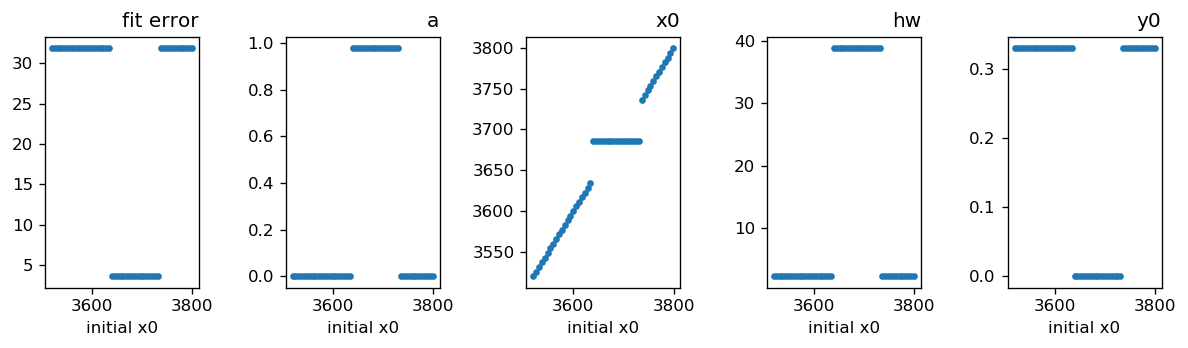

In [48]:
margin = 0
#margin = 50
x0s = np.linspace(min(xy[:,0])+margin, max(xy[:,0])-margin, 50)
errs = []
#print (x0s)

#p0 = [1., None, 30.]
#p0 = [1., None, 30., 0.1]
#p0 = [1., None, 1., .1]

#use_derivs = False
use_derivs = True

for i,x0 in enumerate(x0s):
    p0[1] = x0
    
    res = sp_opt.minimize(peak_fit, p0, args=(xy[:, 0], 2 if use_derivs else 1),
                          method='l-bfgs-b', 
                          jac=use_derivs,
                          bounds = [(1e-10,1e10)]* len(p0)
                         )
    if res.success:
        errs.append( [x0, res.fun] + list(res.x) )
    else:
        print ('Failed:', x0, res.message)
#
errs = np.array(errs)
fig, axs = plt.subplots(ncols=errs.shape[1]-1, figsize=(10,3))
for a, e, lbl in zip(axs, errs.T[1:], ['fit error', 'a', 'x0', 'hw', 'y0']):    
    a.plot(errs[:,0], e, '.')
    a.set_title(lbl,loc='right')
    a.set_xlabel('initial x0')
plt.tight_layout()
plt.show()
    

### частина 2 - апроксимація реалістичним спектром вісесиметричного ротатора

Для квантово-механічного опису обертального руху можна увести гамільноніан жорсткого ротатора
$$
\hat H_{rot} = \frac{{\hat L_a ^2 }} {{2I_a }} + \frac{{\hat L_b ^2 }} {{2I_b }} + \frac{{\hat L_c ^2 }} {{2I_c }}
\label{eq:Hrot} \tag{1}
$$
який засновано на наближенні, що головні моменти інерції молекули $I_a$, $I_b$, $I_c$  є незмінними попри її коливальний та інші рухи.


У випадку $I_a = I_b \ne I_c$ молекула належить до так званого типу вісесиметричного ротатора, а енергії її обертальних станів описуються виразом

$$
E_{JKM} = A \cdot \left( J(J + 1) - K^2 \right) + C \cdot K^2 = \color{blue} {  A \cdot J\cdot (J + 1) + \left(C - A\right) \cdot K^2 
}
\label{eq:EJKM} \tag{2}
$$

де було уведено *обертальні сталі* $  A = \frac{{\hbar ^2 }} {{2I_a }} $, $  B = \frac{{\hbar ^2 }}{{2I_b }}$ (у вісесиметричного ротатора $A=B$), 
$  C = \frac{{\hbar ^2 }}{{2I_c }} $, які мають розмірність енергії. Останню в спектроскопії часто ділять на сталу Планка і виражають в специфічних одиницях вимірювання частоти - обернених сантиметрах ($\texttt{см}^{-1}$), ${\tilde \nu } \left[ \texttt{см}^{-1} \right] = \frac{1}{\lambda \left[ см \right]}$, де $\lambda \left[ см \right]$ - довжина хвилі, виражена в сантиметрах. Таке означення є прийнятним з огляду на зв'язок $\lambda \cdot \nu = c$ між частотою $\nu$ і довжиною хвилі $\lambda$ електромагнітної хвилі.


Квантовими числами вісесиметричного ротатора є $J$ (може набувати цілочисельних значень 0, 1, 2, ...), $K$, $M$ (два останні можуть приймати цілі значення від $-J$ до $+J$), причому енергія обертального стану залежить лише від $J$ та $K$ (стани є $(2J+1)$-кратно виродженими за $M$).


При реєстрації безпосередньо обертальних спектрів поглинання, частота кванта світла, який поглинається молекулою при її переході з одного обертального стану ($\left| {J,K,M} \right\rangle $) в інший ($\left| {J',K',M'} \right\rangle$), пов'язана з енергіями цих станів звичною формулою 
$$
\nu  = \frac{{E_{J'K'M'}  - E_{JKM} }}{h}
\label{eq:nu1} \tag{3}
$$
Однак, коли ідеться про переходи між обертальними *"під-рівнями"* коливальних станів, початковий $\left| {J,K,M} \right\rangle $ і кінцевий $\left| {J',K',M'} \right\rangle$ обертальні стани належать двом різним "коливальним рівням", а тому (3) змінюється на 
$$
\nu  = \frac{{\left( {E_{vib'}  + E_{J'K'M'} } \right) - \left( {E_{vib}  + E_{JKM} } \right)}}{h} = \color{blue}{ \nu _0  + \frac{{E_{J'K'M'}  - E_{JKM} }}{h} }
\label{eq:nu2} \tag{4}
$$
де ${E_{vib} }$ і ${E_{vib'} }$ - енергії початкового і кінцевого коливальних станів, а $\nu _0$ - частота, на якій молекула поглинала б світло, якби відбувалися переходи лише між коливальними станами, а вільного обертання молекули не було б; $\nu _0  = \left( {E_{vib'}  - E_{vib} } \right)/h$.

Нарешті, щоб з'ясувати, на які "зсуви" $\left(E_{J'K'M'}  - E_{JKM} \right) / h $ в спостережуваному спектрі поглинання зміщуватиметься частота $\nu _0$ "чистого" коливального переходу внаслідок наявності в молекули переходів між обертальними станами, необхідно врахувати **правила відбору**.

Між станами вісесиметричного ротатора можливі переходи двох типів "пералельні" та "перпендикулярні", залежно від типу відрізняються правила відбору - зміна $\Delta J$ та $\Delta K$, яких можуть зазнавати квантові числа $J$ та $K$ при переходах, які супроводжуються поглинанням світла.

<table>
    <tr><td>початковий стан</td><td>"пералельні" ($Zz$)</td><td>"перпендикулярні" ($Zx$, $Zy$)</td></tr>
    <tr><td>$$J = 0$$</td>
                <td>                    
                    <li>$$\Delta J = +1, \Delta K = 0$$</li>
                </td>
                <td>
                    <li>$$\Delta J = +1, \Delta K = \pm 1$$</li>
                </td>
    </tr>
    <tr><td>$$J > 0$$</td>
                <td>                    
                    <li>$$\Delta J = 0, \Delta K = 0$$ - дозволений лише при $K \ne 0$</li>
                    <li>$$\Delta J = \pm 1, \Delta K = 0$$</li>
                </td>
                <td>
                    <li>$$\Delta J = \pm 1, \Delta K = \pm 1$$</li>
                    <li>$$\Delta J = 0, \Delta K = \pm 1$$</li>
                </td>
    </tr>
</table>

Назви цих типів обумовлені орієнтацією проекцій вектора дипольного моменту відносно напрямку вектора напруженості електричного поля падаючого на систему електромагнітного випромінювання. 

У реальному спектрі спостерігатиметься лінії поглинання від переходів обох типів (з таблиці видно, що правила відбору, а отже - і частоти, у таких переходів відрізняються!), але співвідношення між інтенсивностями перходів одного і іншого типу *визначатиметься орієнтацією вектора дипольного мементу молекули відносно її головних осей інерції*. **Таке співвідношення вважатимемо вільним параметром моделі, який необхідно знайти за результатами апроксимації спектру**.

Інтенсивності переходів "паралельного" і "перпендикулярного типу" також відрізняються. Ці інтенсивності з точністю до множника, який не залежить від $J$, $K$, $M$, пропорційні наступним матричним елементам:
Для переходів "паралельного" типу
$$
I_{ + 1,0}  = \sum\limits_{M,M'}^{} {\left| \left\langle {J,K,M} \right|\Phi _{Zz} \left| {J + 1,K,M'} \right\rangle \right|^2}  = 2 \cdot \frac{{(J + K + 1) \cdot (J - K + 1)}}{{J + 1}}
\label{eq:eq5} \tag{5}
$$

$$
I_{ - 1,0}  = \sum\limits_{M,M'}^{} {\left| \left\langle {J,K,M} \right|\Phi _{Zz} \left| {J - 1,K,M'} \right\rangle \right|^2}  = 2 \cdot \frac{{J^2  - K^2 }}{J}
\label{eq:eq6} \tag{6}
$$

$$
I_{0,0}  = \sum\limits_{M,M'}^{} {\left| \left\langle {J,K,M} \right|\Phi _{Zz} \left| {J,K,M'} \right\rangle \right|^2}  = 2 \cdot \frac{{(2 \cdot J + 1) \cdot K^2 {\rm{ }}}}{{J \cdot (J + 1)}}
\label{eq:eq7} \tag{7}
$$

Для переходів "перпендикулярного" типу

$$
I_{ + 1, \pm 1}  = \sum\limits_{M,M'}^{} {\left( {\left| {\left\langle {J,K,M} \right|\Phi _{Zy} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2  + \left| {\left\langle {J,K,M} \right|\Phi _{Zx} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2 } \right)}  = \frac{{(J \pm K + 1) \cdot (J \pm K + 2)}}{{J + 1}}
\label{eq:eq8} \tag{8}
$$

$$
I_{0, \pm 1}  = \sum\limits_{M,M'}^{} {\left( {\left| {\left\langle {J,K,M} \right|\Phi _{Zy} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2  + \left| {\left\langle {J,K,M} \right|\Phi _{Zx} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2 } \right)}  = \frac{{(2 \cdot J + 1) \cdot (J \mp K) \cdot (J \pm K + 1)}}{{{\rm{ }}J \cdot (J + 1)}}
\label{eq:eq9} \tag{9}
$$

$$
I_{ - 1, \pm 1}  = \sum\limits_{M,M'}^{} {\left( {\left| {\left\langle {J,K,M} \right|\Phi _{Zy} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2  + \left| {\left\langle {J,K,M} \right|\Phi _{Zx} \left| {J + 1,K \pm 1,M'} \right\rangle } \right|^2 } \right)}  = \frac{{(J \mp K) \cdot (J \mp K - 1)}}{J}
\label{eq:eq10} \tag{10}
$$
(де нижні індекси позначають зміни чисел $J$ та $K$).
При цьому дозволений перехід (будь якого з типів) має мати допустимі значення чисел $K'$ та $J'$, тобто має виконуватися $\left| {K'} \right| \le J'$.




Нарешті, в експериментально виміряному спектрі кожен з дозволених переходів відображатиметься не як окрема вертикальна лінія на частоті $f = \nu$, а як центрований навколо частоти переходу $\nu$ контур
$$
I_{sp}(f) = y_0  + \frac{a}{{1 + \left( {\frac{{f - \nu }}{w}} \right)^2 }}
\label{eq:eq11} \tag{11}
$$
характерна ширина $w$ якого обумовлена скінченою роздільною здатністю спектрометра, а амплітуда $a$ - однаковим для всього спектра коефіцієнтом пропорційності, інтенсивностями (5)-(10) відповідних ліній, а також - заселеністю стану, *з якого* відбувається перехід. Її можна знайти з розподілу Больцмана як пропорційну до 
$$
p_{JKM}  = A \cdot \exp \left( { - \frac{{E_{vib}  + E_{JKM} }}{{k_B T}}} \right) \approx \color{blue}{\tilde A \cdot \exp \left( { - \frac{{E_{JKM} }}{{k_B T}}} \right)}
\label{eq:eq12} \tag{12}
$$
де $A$ $ та \tilde A $ - деякі сталі, а зроблене знаближення враховує те, що через як правило велику (порівняно з $k_B \cdot T$) "відстань" між коливальними рівнями (якщо коливання мають частоти $~10^3 \texttt{см}^{-1}$ і більше), можливі лише з основного у перший збуджений коливальний стан.

Таким чином, функція, якою можна за методом найменших квадратів здійсними апроксимацію експериментально виміряного спектра поглинання газу з молекул, що можуть обертатися і мають активні коливальні переходи, є досить складною, і утворюється **поєднанням фопмул (2)-(12)**.

Разом з тим, **підгоночними параметрами**, які відтак можна знайти у результаті апроксимації, є лише **дві обертальні сталі** ($A$ та $C$), **дві амплітуди** (для групи ліній "паралельного" і "перпендикулярного" типу переходів відповідно) і **частота $\nu_0$**.
Звичайно, можна прийняти за підгоночні і інші параметри модель, наприклад - характерну ширину $w$ контура, стале зміщення всієї функції по вертикальній осі ($y_0$) тощо.

In [49]:
# Symmetric top only !

# note that these intensities are already summed over both M and M' !
intensities = lambda J,K: {
    # intensities: [H. C. Allen, P.  C. Cross. Molecular Vib-rotors: The Theory and 
    # Interpretation of High Resolution Infra-red Spectra // Wiley, 1963. - pp.103-104
        # || - type:
        # (J,K || J+1, K)
    (+1,0): 2*(J+K+1)*(J-K+1)*1. / (J+1) , # note that '-delta_{K,0}' is not needed
        # (J,K || J-1, K)
    (-1,0): 2*(J**2 - K **2)*1. / J if J!=0 else None,
        # (J,K || J,K) 
    (0,0):  2*(2*J+1)*K**2 * 1. / J / (J+1) if J!=0 else None,
     
        # _|_ - type:
        # (J,K || J+1, K+1)
    (+1,+1): (J+K+1)*(J+K+2)*1. / (J+1),
        # (J,K || J+1, K-1)
    (+1,-1): (J-K+1)*(J-K+2)*1. / (J+1),
    
        # (J,K || J, K+1)
    (0,+1):  (2*J+1)*(J-K)*(J+K+1)*1. / J / (J+1) if J!=0 else None,
        # (J,K || J, K-1)
    (0,-1):  (2*J+1)*(J+K)*(J-K+1)*1. / J / (J+1) if J!=0 else None,
     
        # (J,K || J-1, K+1)
    (-1,+1): (J-K)*(J-K-1)*1. / J if J!=0 else None,
        # (J,K || J-1, K-1)
    (-1,-1): (J+K)*(J+K-1)*1. / J if J!=0 else None
}

precomputed_lines = [] # list of [
                       #   coef_at_rotA_state1, coef_at_rotCA_state1, 
                       #   coef_at_rotA_state2, coef_at_rotCA_state2,
                       #   intensity,
                       #   J_from, 
                       #   line_type  ( 1.0 == 'z', 2.0 == 'x'+'y')

def rot_ene_cofes(J,K):
    return [J*(J+1), K**2] # coefs at rotA, rotCA in rotA * J*(J+1) + rotCA2 * K**2

jMax = 100

# || - type:
# K != 0  =>  DJ = 0, -1, +1;   DK = 0
# K == 0  =>  DJ =    -1, +1;   DK = 0
# _|_ - type:
# DJ = 0, -1, +1; DK = -1, +1

# J==0 -- 1 || transition and 2 _|_ transitions
J = 0
e1 = rot_ene_cofes(0,0)
inteDict = intensities(0,0)
# || - type
e2 = rot_ene_cofes(1,0)
precomputed_lines.append( e1+e2+[ inteDict[(+1, 0)], J, 1  ] )

# _|_ - type
e2 = rot_ene_cofes(1, +1)
precomputed_lines.append( e1+e2+[ inteDict[(1, +1)], J, 2  ]  )
e2 = rot_ene_cofes(1, -1)
precomputed_lines.append( e1+e2+[ inteDict[(1, -1)], J, 2  ]  )

# J > 0
for J in range(1,jMax):    
    for K in range(-J, J+1):

        e1 = rot_ene_cofes(J,K)
        inteDict = intensities(J,K)
        # || - type
        for DJ in [-1, 1]:
            if abs(K)<=J+DJ: # note that J+DJ>=0 always!
                e2 = rot_ene_cofes(J+DJ,K)
                precomputed_lines.append( e1+e2+[ inteDict[(DJ, 0)], J, 1  ]  )
        # DJ=0, DK=0 is only possible for K!=0
        if K != 0:
            e2 = rot_ene_cofes(J,K)
            precomputed_lines.append( e1+e2+[ inteDict[(0, 0)], J, 1  ]  )

        # _|_ - type
        for DJ in [0, -1, +1]:
            for DK in [-1, +1]:
                if K+DK>=-(J+DJ) and K+DK<=(J+DJ) :  # note that J+DJ>=0 always!
                    e2 = rot_ene_cofes(J+DJ,K+DK)
                    precomputed_lines.append( e1+e2+[ inteDict[(DJ, DK)], J, 2  ]  )
        #
    #
#
precomputed_lines = np.array(precomputed_lines)
precomputed_lines[:, 4] /= len(precomputed_lines)

print(len(precomputed_lines), 'lines')


89103 lines


In [50]:
precomputed_lines[-1]

array([9.90000000e+03, 9.80100000e+03, 1.01000000e+04, 1.00000000e+04,
       4.46674074e-03, 9.90000000e+01, 2.00000000e+00])

In [51]:
typical_rot_A = 1.
typical_rot_CA = 1.
bool1 = abs(typical_rot_A*(precomputed_lines[:,2]-precomputed_lines[:,0]) + 
         typical_rot_CA*(precomputed_lines[:,3]-precomputed_lines[:,1]))  < 100
bool2 = (typical_rot_A*precomputed_lines[:,0]) + typical_rot_CA*precomputed_lines[:,1]  < 1500

precomputed_lines = precomputed_lines[ bool1 & bool2 ]
print (len(precomputed_lines))
#len( np.where( )[0] )

10221


CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 813 ms


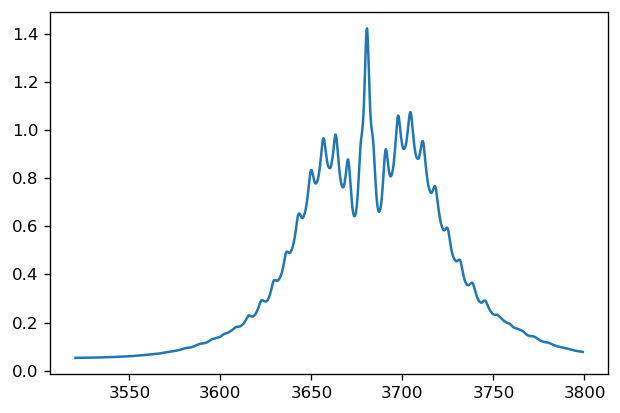

In [52]:
#%%timeit -n 1 -r 1
# CH3OH
# Rotational temperatures (Kelvin)      6.16958     1.18254     1.14202
# Rotational constants (GHZ):         128.55336    24.64015    23.79578 
# Rotational Constants (cm-1)           4.28808     0.82191     0.79374
# Inertia Moments (amu-Ang**2)          3.93128    20.51038    21.23817
# Symmetric top model assumes that A=B != C
# rotA = (0.8219+0.7937)/2, rotCA = 4.2880 - (0.8219+0.7937)/2


x0 = [0.865, 3.417,  93.5, 65.0, 3680.5, 0.05] # meth, 1.9

x0 = np.array(x0)

def rot_func(X, t):
    rotA_from, rotCA_from,   aRot1, aRot2,    nu0, y0  = X
    hw = 2.
    rotA_to = rotA_from
    rotCA_to = rotCA_from    
    
    freqs = t
    y = freqs*0.
    y += y0
       

    beta = 1./(205.7) # 23 C = 276 K
    
    # контур 1 лінії обертального переходу
    def lineshape(x):
        return 1./( (x/hw)**2 + 1 )        
    #
    
    for el in precomputed_lines:
        eFrom = rotA_from*el[0] + rotCA_from*el[1]
        eTo   = rotA_to  *el[2] + rotCA_to  *el[3]
        shift = eTo-eFrom
        nu = nu0 + shift
        if el[-1] < 2:
            ampl = aRot1
        else:
            ampl = aRot2
        #
        y += np.exp(-beta*eFrom) * lineshape(freqs - nu) * el[4] * ampl
    #               
    return y
#

t = np.linspace(min(xy[:,0]), max(xy[:,0]), 1000)

%time y = rot_func(x0, t)

plt.plot(t,y)
plt.show()    

In [53]:
%%time
def fit_err(P):
    dy = rot_func(P, xy[:, 0]) - xy[:, 1]
    return dy.dot(dy)
#
sp_opt.approx_fprime(x0, fit_err, 1e-6)

CPU times: user 4.14 s, sys: 0 ns, total: 4.14 s
Wall time: 4.18 s


array([-11.13002312,  -1.32779487,   0.04445932,   0.09546324,
         0.04770913,  26.16622633])

Якщо увести позначення 
$$e_i  = f\left( {x_i ;P_1 ,...,P_m } \right) - y_i $$
де через $P_k$ позначено параметри моделі, то похідну похибки апроксимації 
$$E = \sum\limits_i^{} {e_i ^2 } $$
за $P_k$, - а така похідна буде водночас $k$-ю компонентою градієнта функції $E(...P_k...)$, яку слід мінімізувати, - можна  знайти як
$$
g_k  = \frac{\partial }{{\partial P_k }}\sum\limits_i^{} {e_i ^2 }  = \frac{\partial }{{\partial P_k }}\left( {{\bf{e}}^T {\bf{e}}} \right) = 2\sum\limits_i^{} {e_i \frac{{\partial e_i }}{{\partial P_k }}}  = \color{blue}{2\sum\limits_i^{} {e_i \frac{{\partial \left( {f(x_i ;P_1 ,...) - y_i } \right)}}{{\partial P_k }}}}  = 2\sum\limits_i^{} {J_{ki} e_i } 
$$
де величини
$$
J_{ki}  = \frac{{\partial f(x_i ;P_0 ,...)}}{{\partial P_k }}
$$
можна об'єднати у прямокутну матрицю ${\bf{J}}$. Тоді вектор градієнта похибки буде
$$
\color{blue}{
{\bf{g}} = 2{\bf{Je}}
}
$$

      fun: 0.9568474324701047
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.16152273e-05, -1.59867180e-05,  0.00000000e+00,  0.00000000e+00,
        3.73675880e-07,  2.93434149e-07,  5.09527462e-07,  6.13392872e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 60
   status: 0
  success: True
        x: array([7.47864290e-01, 2.83672652e+00, 1.00000000e-10, 1.00000000e-10,
       7.31137912e+01, 4.70317602e+01, 3.68042529e+03, 3.80446516e-02])


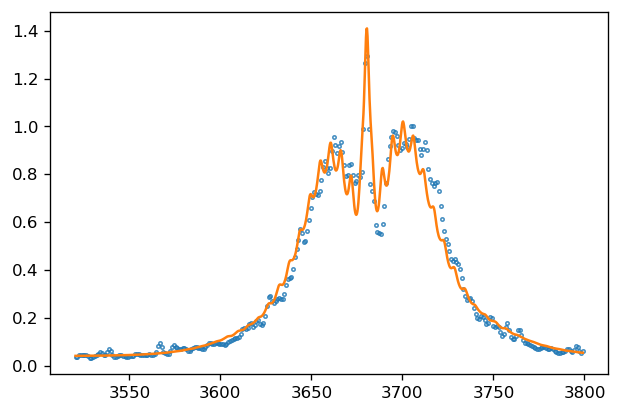

CPU times: user 2min 38s, sys: 4.84 ms, total: 2min 38s
Wall time: 2min 39s


In [67]:
%%time
#%%timeit -n 1 -r 1
# CH3OH
# Rotational temperatures (Kelvin)      6.16958     1.18254     1.14202
# Rotational constants (GHZ):         128.55336    24.64015    23.79578 
# Rotational Constants (cm-1)           4.28808     0.82191     0.79374
# Inertia Moments (amu-Ang**2)          3.93128    20.51038    21.23817
# Symmetric top model assumes that A=B != C
# rotA = (0.8219+0.7937)/2, rotCA = 4.2880 - (0.8219+0.7937)/2

x0 = [2., 1.0,   0,0,  80.0, 40.0, 3680, 3e-2]
#x0 = [7.47860804e-01, 2.83672350e+00, 1.00000000e-10, 1.00000000e-10, 7.31126468e+01, 4.70317768e+01, 3.68042530e+03, 3.80450878e-02]
#x0 = [7.47860804e-01, 2.83672350e+00, 7.47860804e-01, 2.83672350e+00, 7.31126468e+01, 4.70317768e+01, 3.68042530e+03, 3.80450878e-02]

x0 = np.array(x0)

dontUse_rotA_to, dontUse_rotCA_to = True, True
#dontUse_rotA_to, dontUse_rotCA_to = False, False

param_names = ['rotA_from', 'rotCA_from',  'rotA_to', 'rotCA_to',   'aRot1', 'aRot2',  'nu0', 'y0']

def fit(X, return_deriv = True, t=None):
    rotA_from, rotCA_from,   rotA_to, rotCA_to,   aRot1, aRot2,    nu0, y0  = X

    hw = 1.9

    if dontUse_rotA_to:
        rotA_to = rotA_from
    if dontUse_rotCA_to:
        rotCA_to = rotCA_from
    
    
    freqs = xy[:, 0] if t is None else t
    y = freqs*0.
    y += y0

    y_derivs = np.zeros((len(X), len(freqs)))
        

    beta = 1./(205.7) # 23 C = 276 K
    
    # контур 1 лінії обертального переходу та його похідні за пареметрами
    def lineshape(x):
        p = 1./( (x/hw)**2 + 1 )        
        return p, - p/hw**2 * 2*x 
        # value , 1/value * d_value/d_nu0
    #

    
    for el in precomputed_lines:
        eFrom = rotA_from*el[0] + rotCA_from*el[1]
        eTo   = rotA_to  *el[2] + rotCA_to  *el[3]
        shift = eTo-eFrom
        nu = nu0 + shift
        line_val, dlineEx_dnu = lineshape(freqs - nu)
        contrib = np.exp(-beta*eFrom) * line_val * el[4]
        if el[-1] < 2:
            ampl = aRot1
            y_derivs[4] += contrib
        else:
            ampl = aRot2
            y_derivs[5] += contrib
        #
        contrib *= ampl
        y += contrib
        y_derivs[0] += contrib * ( (-beta) * el[0] + dlineEx_dnu * (-1) * (-1) * el[0] ) # A_from
        y_derivs[1] += contrib * ( (-beta) * el[1] + dlineEx_dnu * (-1) * (-1) * el[1] ) # CA_from
        y_derivs[2] += contrib * (                   dlineEx_dnu * (-1) *        el[2] ) # A_to
        y_derivs[3] += contrib * (                   dlineEx_dnu * (-1) *        el[3] ) # CA_to
        y_derivs[6] += contrib * dlineEx_dnu * (-1)
    #        
    y_derivs[7] = 1.0
    #    
    if dontUse_rotA_to:
        y_derivs[0] += y_derivs[2]
        y_derivs[2] = 0
    if dontUse_rotCA_to:
        y_derivs[1] += y_derivs[3] 
        y_derivs[3] = 0
    #
        
    
    if t is None:
        dy = y - xy[:, 1]
        if return_deriv:
            return dy.dot(dy), 2. * y_derivs.dot(dy)
        else:
            return dy.dot(dy)
    else:
        return y, y_derivs
#

plt.plot(xy[:,0], xy[:,1], '.', mfc='none', markersize=4, alpha=.8)
t = np.linspace(min(xy[:,0]), max(xy[:,0]), 1000)
if 0:
    y, dydp = fit(x0, False, t)
    plt.plot(t,y)
else:
    use_der = True
    res = sp_opt.minimize(fit, x0, args=(use_der,),
                          method='l-bfgs-b', 
                          #method='cg',
                          jac=use_der,
                          #method='Powell',
                          #options=dict(maxiter=50, ftol=1e-20,gtol=1e-10, maxls=100),
                          bounds=[(1e-10, 1e10) for i in x0])
    print(res)
    y, dydp = fit(res.x, False, t)
    plt.plot(t,y)
plt.show()
    

In [129]:
%%time
y, dydp = fit(x0, False, t)

CPU times: user 2.43 s, sys: 0 ns, total: 2.43 s
Wall time: 2.46 s


In [128]:
%%time
print( sp_opt.approx_fprime(x0, fit, 1e-6, False) )

[  15.79669537    2.81071089    0.            0.           -0.11533255
   -0.26517207   -0.25683134 -106.94385288]
CPU times: user 19.8 s, sys: 0 ns, total: 19.8 s
Wall time: 20.1 s


In [130]:
%time fit(x0, True)

CPU times: user 1.91 s, sys: 0 ns, total: 1.91 s
Wall time: 1.94 s


(29.452616721615247,
 array([  15.79669625,    2.81070964,    0.        ,    0.        ,
          -0.11533255,   -0.26517209,   -0.25683138, -106.94414288]))

      fun: 0.4757206702556313
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09992065e-05,  3.69879599e-04, -9.46237938e-05, -3.58563473e-04,
        1.23215327e-07, -2.11182557e-07, -8.13088108e-06,  2.39792409e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 190
      nit: 162
   status: 0
  success: True
        x: array([8.07660278e-01, 2.90014490e+00, 8.11155995e-01, 2.82545499e+00,
       1.00364659e+02, 4.03961772e+01, 3.68231283e+03, 4.10804361e-02])


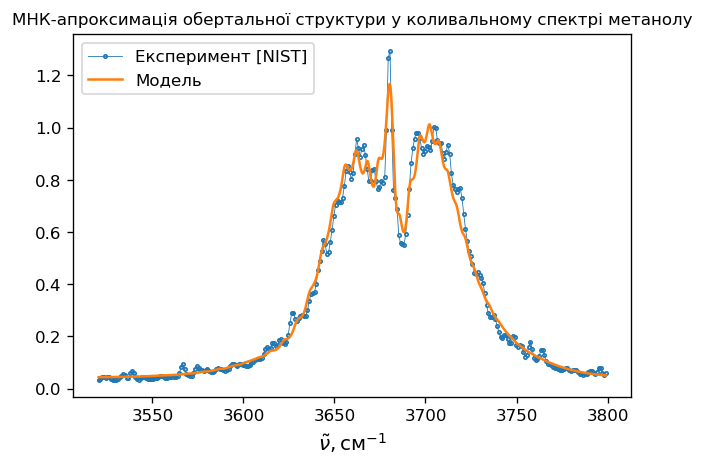

CPU times: user 6min 33s, sys: 17.7 ms, total: 6min 33s
Wall time: 6min 35s


In [68]:
%%time
x0 = [7.47860804e-01, 2.83672350e+00, 
      7.47860804e-01, 2.83672350e+00, 
      7.31126468e+01, 4.70317768e+01, 
      3.68042530e+03, 3.80450878e-02]

x0 = np.array(x0)

dontUse_rotA_to, dontUse_rotCA_to = False, False

use_der = True
res = sp_opt.minimize(fit, x0, args=(use_der,),
                      method='l-bfgs-b', 
                      jac=use_der,
                      bounds=[(1e-10, 1e10) for i in x0])
print(res)

plt.plot(xy[:,0], xy[:,1], '.-', mfc='none', markersize=4, label="Експеримент [NIST]", linewidth=.5)
y, dydp = fit(res.x, False, t)
plt.plot(t,y, label="Модель")
plt.xlabel(r'$\tilde{\nu}, \mathrm{см}^{-1}$', fontsize=12)
plt.legend(loc='best')
plt.title(u"МНК-апроксимація обертальної структури у коливальному спектрі метанолу", fontsize=10)
#plt.savefig('_sp_pic.png', dpi=200, bbox_inches='tight')
plt.show()

$$
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

Оцінимо похибки одержаних параметрів.


Нехай при апроксимаціїапроксимацію значень $\{x_\mu, y_\mu\}$ значеннями функції $f(x_\mu  ;{\bf{p}})$ ми змістили кожне   $y_\mu$, замінивши його на  $y_\mu + \varepsilon _\mu $. Для того, щоб знайти, до яких змін $\sigma _i$ у параметрах $p_i$ порівняно з їх "старими" значеннями  $p_i^0$ це призведе, покладемо $p_i  = p_i ^0  + \sigma _i $ і скористаємося наближенням
$$
f(x_\mu  ;{\bf{p}}) \approx f(x_\mu  ;{\bf{p}}_0 ) + \sum\limits_i^{} {\left( {\frac{{\partial f}}{{\partial p_i }}} \right)_{{\bf{p}}_0 }  \cdot \sigma _i } 
$$
Позначимо
$$
J_{i,\mu} = \left( \frac{ \partial f(x_{\mu}) } { \partial p_i} \right) _ {\vec{p}_0}
$$

Тоді для пошуку $\sigma _i$  достатньо мінімізувати вираз для похибки
$$
E(\sigma _i ) = \sum\limits_\mu ^{} {\left( {y_\mu   + \varepsilon _\mu   - f(x_\mu  ;{\bf{p}}_0 ) - \sum\limits_i^{} {J_{i\mu }  \cdot \sigma _i } } \right)^2 } 
$$
Це дає
$$
\frac{{\partial E}}{{\partial \sigma _k }} = 2\sum\limits_\mu ^{} {\left( {y_\mu   + \varepsilon _\mu   - f(x_\mu  ;{\bf{p}}_0 ) - \sum\limits_i^{} {J_{i\mu }  \cdot \sigma _i } } \right)J_{k\mu } }  = 0
$$

$$
 \sum\limits_\mu ^{} {J_{k\mu } \left( {y_\mu   - f(x_\mu  ;{\bf{p}}_0 )} \right)}  + \sum\limits_\mu ^{} {J_{k\mu } \varepsilon _\mu  }  - \sum\limits_i^{} {\left( {{\bf{JJ}}^T } \right)_{ki} \sigma _i }  = 0
$$
що можна переписати в матричній формі як
$$
{\bf{JJ}}^T {\bf{\sigma }} = {\bf{J}(-\bf{e})} + {\bf{J\varepsilon }}
$$
якщо увести вектор $\bf{e}$ з компонентами $ e_\mu   = f(x_\mu  ;{\bf{p}}_0 ) - y_\mu $
Тоді розв'язком буде
$$
{\bf{\sigma }} = \left( {{\bf{JJ}}^T } \right)^{ - 1} \left( {{\bf{J} (-\bf{e})} + {\bf{J\varepsilon }}} \right)
$$
причому якщо параметри $\bf{p}_0 $ було знайдено з мінімізації похибки $E(\bf{\sigma})$ коли "збурення" були відсутні ( $\varepsilon_{\mu} = 0$), то ще більше мінімізувати цю похибку невеликими добавками $\sigma_i$ до параметрів $p_i$ неможна, а тому має бути $\left( {{\bf{JJ}}^T } \right)^{ - 1} {\bf{J}(-\bf{e})} = \bf{0} $. Таким чином, за цих умов одержуємо
$$
{\bf{\sigma }} = \left( {{\bf{JJ}}^T } \right)^{ - 1} {\bf{J\varepsilon }}
$$
Одержаний вираз аналогічний до виразу для зв'язку похибки оцінки параметрів з похибками вхідних даних в звичайному лінійному методі найменших квардатів. Продовжуючи цю аналогію, за умови, що похибки $\varepsilon_{\mu}$ всіх $y_{\mu}$ є незалежними, а $\left\langle {\varepsilon _\mu  } \right\rangle  = 0 $ і $\left\langle {\varepsilon _\mu  ^2 } \right\rangle  = s^2 $, дістенемо для коваріаційної матриці $\left\langle {{\bf{\sigma \sigma }}^T } \right\rangle $ (елементи якої $
\left( {\left\langle {{\bf{\sigma \sigma }}^T } \right\rangle } \right)_{ij}  = \left\langle {\left( {p_i  - p_i ^0 } \right)\left( {p_j  - p_j ^0 } \right)} \right\rangle $ характеризують "похибки" параметрів $p_i$)
$$
\left\langle {{\bf{\sigma \sigma }}^T } \right\rangle  = s^2  \cdot \left( {{\bf{JJ}}^T } \right)^{ - 1} {\bf{JJ}}^T \left( {{\bf{JJ}}^T } \right)^{ - 1}  = s^2  \cdot \left( {{\bf{JJ}}^T } \right)^{ - 1} 
$$
Зокрема, діагональні компоненти цієї матриці дають дисресії для параметрів моделі
$$
\delta_{p_i} = \sqrt{  \left\langle {\left( {p_i  - p_i ^0 } \right) ^ {2}} \right\rangle  } = s \cdot \sqrt { \left( \left( {{\bf{JJ}}^T } \right)^{-1}\right)_{ii} }
$$
За *орієнтовну оцінку* величини $s$ можна прийняти 
$$
s = \sqrt {\frac{1}{{n_{\bf{y}}  - n_{\bf{p}} }}\sum\limits_\mu ^{} {\left( {y_\mu   - f(x_\mu  ;{\bf{p}}_0 )} \right)^2 } }  = \sqrt {\frac{{E(0)}}{{n_{\bf{y}}  - n_{\bf{p}} }}} 
$$


In [69]:
import sys

In [70]:
p0 = res.x
y, dydp = fit(p0, return_deriv=True, t=xy[:, 0])
dy = y - xy[:, 1]
print('||dy||=', dy.dot(dy)**.5)

# remove unused variables
idx = list(range(len(p0)))
if dontUse_rotA_to:
    idx.remove(2)
if dontUse_rotCA_to:
    idx.remove(3)
J = dydp[idx, :]

s = (dy.dot(dy) /(len(xy[:,1] - len(idx)))) ** 0.5
print ('Estimated s:', s)

covMatr = np.linalg.inv( J.dot(J.T) )

dsScales = 1/covMatr.diagonal()**0.5
print('Parameter correlation matrix')
c = np.multiply(covMatr, np.outer(dsScales, dsScales))
print(''.join('%11s' % param_names[i][:10] for i in idx))
np.savetxt(sys.stdout, c, fmt='%10.3f', delimiter=' ')
#np.savetxt(sys.stdout, covMatr, fmt='%12.1E')

perr = covMatr.diagonal() ** 0.5 * s 

print('Params & errors')
#print (np.vstack((p0, perr)).T )
for i, xval,xerr in zip(idx, p0[idx], perr):
    print ('%20s = %12.5f +/-    %7.5f' % (param_names[i], xval,  xerr) )


||dy||= 0.6897250686002585
Estimated s: 0.040502050618823775
Parameter correlation matrix
  rotA_from rotCA_from    rotA_to   rotCA_to      aRot1      aRot2        nu0         y0
     1.000      0.014      0.999     -0.067      0.763      0.093      0.085     -0.138
     0.014      1.000      0.017      0.986      0.180      0.044      0.024     -0.057
     0.999      0.017      1.000     -0.065      0.764      0.094      0.054     -0.141
    -0.067      0.986     -0.065      1.000      0.099      0.061     -0.040     -0.054
     0.763      0.180      0.764      0.099      1.000     -0.481      0.143      0.123
     0.093      0.044      0.094      0.061     -0.481      1.000     -0.133     -0.650
     0.085      0.024      0.054     -0.040      0.143     -0.133      1.000      0.086
    -0.138     -0.057     -0.141     -0.054      0.123     -0.650      0.086      1.000
Params & errors
           rotA_from =      0.80766 +/-    0.01264
          rotCA_from =      2.90014 +/-    0.02903

In [71]:
#xy.shape

In [72]:
#typical_rot_A = 1.
#typical_rot_CA = 1.
#vals = typical_rot_A*(precomputed_lines[:,2]-precomputed_lines[:,0]) + typical_rot_CA*(precomputed_lines[:,3]-precomputed_lines[:,1])
#max(vals)